In [2]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.functional as F
from torch.autograd import Function
import optuna
from modules import Trainer
from modules.competition_dataset import EEGDataset
from modules.utils import evaluate_model
import random
import numpy as np
from torch.utils.data import ConcatDataset, random_split, DataLoader
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

/home/zeyadcode/.pyenv/versions/icmtc_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cpu')

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# data_path = '/content/drive/MyDrive/ai_data/eeg_detection/data/mtcaic3'
# model_path = '/content/drive/MyDrive/ai_data/eeg_detection/checkpoints/ssvep/models/ssvep.pth'
# optuna_db_path = '/content/drive/MyDrive/ai_data/eeg_detection/checkpoints/ssvep/optuna/optuna_studies.db'
data_path = './data/mtcaic3'
model_path = './checkpoints/mi/models/the_honored_one.pth'
optuna_db_path = './checkpoints/mi/optuna/the_honored_one.db'
eeg_channels = [
    "C3", # 2296.15
    "PZ", # 1744.43
    "C4", # 1556.46
    "OZ", # 444.98
    "PO7", # 381.63
    "PO8", # 275.78
    "CZ", # 200.43
    "FZ", # 111.51
]

In [4]:
# Add this at the beginning of your notebook, after imports
def set_random_seeds(seed=42):
    """Set random seeds for reproducibility"""

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Call this function before creating datasets and models
set_random_seeds(42)

In [5]:
window_length = 128 * 2 # ensure divisble by 64 the kernel size
stride = window_length // 3
batch_size = 32

dataset_train = EEGDataset(
    data_path,
    window_length=window_length,
    stride=stride,
    domain="time",
    data_fraction=0.1,
    hardcoded_mean=True,
    task="mi",
    eeg_channels=eeg_channels,
)

dataset_val = EEGDataset(
    data_path=data_path,
    window_length=window_length,
    stride=stride,
    split='validation',
    read_labels=True,
    hardcoded_mean=True,
    data_fraction=1,
    task="mi",
    eeg_channels=eeg_channels,
)

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(dataset_val,   batch_size=batch_size)

task: mi, split: train, domain: time, data_fraction: 0.1
Using 10.0% of data: 240/240 samples
skipped: 0/240
data shape: (4194, 8, 256), mean shape: (1, 8, 1)
task: mi, split: validation, domain: time, data_fraction: 1
skipped: 0/50
data shape: (857, 8, 256), mean shape: (1, 8, 1)


In [9]:
# ---------------- Gradient Reversal Layer ---------------- #
class GradientReversalFunction(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None


class GradientReversal(nn.Module):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.alpha = alpha

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.alpha)


# ---------------- LSTM Head ---------------- #
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        # x: B x seq_len x feat_dim
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device)
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


# ---------------- EEG Feature Extractor ---------------- #
class EEGFeatureExtractor(nn.Module):
    def __init__(self, n_electrodes, kernLength, F1, D, F2, dropout):
        super().__init__()
        # For input B x C x T, apply 2D convs on [C x T]
        self.block = nn.Sequential(
            # Temporal conv across time
            nn.Conv2d(1, F1, (1, kernLength), padding=(0, kernLength // 2), bias=False),
            nn.BatchNorm2d(F1),
            # Depthwise spatial conv across electrodes
            nn.Conv2d(F1, F1 * D, (n_electrodes, 1), groups=F1, bias=False),
            nn.BatchNorm2d(F1 * D),
            nn.ELU(),
            nn.MaxPool2d((1, 2)),
            nn.Dropout(dropout),
            # Separable conv
            nn.Conv2d(F1 * D, F1 * D, (1, 16), padding=(0, 8), groups=F1 * D, bias=False),
            nn.Conv2d(F1 * D, F2, 1, bias=False),
            nn.BatchNorm2d(F2),
            nn.ELU(),
            nn.MaxPool2d((1, 2)),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        # x: B x C x T
        x = x.unsqueeze(1)  # B x 1 x C x T
        x = self.block(x)  # B x F2 x 1 x T_sub
        x = x.squeeze(2)  # B x F2 x T_sub
        x = x.permute(0, 2, 1)  # B x T_sub x F2
        return x


# ---------------- DANN SSVEP Classifier ---------------- #
class DANN_SSVEPClassifier(nn.Module):
    def __init__(
        self,
        n_electrodes=16,
        out_dim=4,
        dropout=0.25,
        kernLength=256,
        F1=96,
        D=1,
        F2=96,
        hidden_dim=100,
        layer_dim=1,
        grl_alpha=0.0,
        domain_lstm_div=3,
        domain_classes=30,
    ):
        super().__init__()
        self.grl_alpha = grl_alpha
        self.feature_extractor = EEGFeatureExtractor(n_electrodes, kernLength, F1, D, F2, dropout)
        feat_dim = F2
        # label predictor (LSTM over time)
        self.label_lstm = LSTMModel(feat_dim, hidden_dim, layer_dim, out_dim)
        # domain predictor
        self.grl = GradientReversal(alpha=grl_alpha)
        self.domain_fc = LSTMModel(feat_dim, max(1, hidden_dim // domain_lstm_div), max(1, layer_dim // domain_lstm_div), domain_classes)

    def forward(self, x):
        # x: B x C x T
        feat_seq = self.feature_extractor(x)  # B x T_sub x feat_dim
        class_out = self.label_lstm(feat_seq)
        
        # feat_avg = feat_seq.mean(dim=1)             # B x feat_dim
        # rev_feat = self.grl(feat_avg)
        # rev_feat = self.grl(feat_seq)

        # domain_out = self.domain_fc(rev_feat)
        # return class_out, domain_out
        return class_out, class_out * 0
    
    def set_grl_alpha(self, alpha):
        """Set the gradient reversal layer alpha value."""
        self.grl.alpha = alpha


dummy_x = torch.randn(5, 8, 256).to(device)
model = DANN_SSVEPClassifier(
    dropout=0.26211635308091535,
    n_electrodes=8,
    out_dim=2,
    domain_classes=30,
    kernLength=256,
    F1=32,
    D=3,
    F2=32,
    hidden_dim=256,
    layer_dim=3,
    grl_alpha=0.2,
    domain_lstm_div=3,
).to(device)

model(dummy_x)[1]
print('worked dude')

worked dude


In [10]:
avg_losses_label = []
avg_losses_domain = []
val_label_accuracies = []
val_domain_accuracies = []
train_label_accuracies = []
train_domain_accuracies = []

In [12]:
# try:
#     model.load_state_dict(torch.load(model_path, weights_only=True))
# except Exception:
#     print("skipping model loading...")


opt = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 20
domain_loss_weight = 0.2

for epoch in range(epochs):
    avg_loss_label = 0
    avg_loss_domain = 0
    correct_label = 0
    correct_domain = 0
    total = 0
    model.train()

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device).to(torch.int64) # shape: [Bx2], 0: label, 1: domain
        y_labels = y[:, 0]
        y_subj = y[:, 1]

        y_pred_labels, y_pred_domain = model(x)

        loss = criterion(y_pred_labels, y_labels)
        # loss_domain = criterion(y_pred_domain, y_subj)
        # loss = loss_label + domain_loss_weight * loss_domain
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        avg_loss_label += loss.item()
        # avg_loss_domain += loss_domain.item()

        # Accuracy calculation
        _, pred_labels = torch.max(y_pred_labels, 1)
        _, pred_domains = torch.max(y_pred_domain, 1)
        correct_label += (pred_labels == y_labels).sum().item()
        correct_domain += (pred_domains == y_subj).sum().item()
        total += y_labels.size(0)

    avg_loss_label /= len(train_loader)
    avg_loss_domain /= len(train_loader)
    avg_losses_label.append(avg_loss_label)
    avg_losses_domain.append(avg_loss_domain)
    train_label_acc = 100.0 * correct_label / total
    train_domain_acc = 100.0 * correct_domain / total
    train_label_accuracies.append(train_label_acc)
    train_domain_accuracies.append(train_domain_acc)

    if (epoch + 1) % 5 == 0:
        label_evaluation, domain_evaluation = evaluate_model(model, val_loader, device)
        val_label_accuracies.append(label_evaluation)
        val_domain_accuracies.append(domain_evaluation)
        model.cpu()
        torch.save(model.state_dict(), model_path)
        model.to(device)
        print(f"{epoch}: avg_loss_label: {avg_loss_label:.3F}, avg_loss_domain: {avg_loss_domain:.3F}, train_label_acc: {train_label_acc:.2f}%, train_domain_acc: {train_domain_acc:.2f}%, label_evaluation: {(label_evaluation*100):.2f}, domain_evaluation: {(domain_evaluation*100):.2f}%, lr: {opt.param_groups[0]['lr']}")

4: avg_loss_label: 0.598, avg_loss_domain: 0.000, train_label_acc: 68.41%, train_domain_acc: 1.69%, label_evaluation: 45.62, domain_evaluation: 0.00%, lr: 0.001
9: avg_loss_label: 0.578, avg_loss_domain: 0.000, train_label_acc: 68.91%, train_domain_acc: 1.69%, label_evaluation: 48.89, domain_evaluation: 0.00%, lr: 0.001
14: avg_loss_label: 0.520, avg_loss_domain: 0.000, train_label_acc: 73.82%, train_domain_acc: 1.69%, label_evaluation: 43.87, domain_evaluation: 0.00%, lr: 0.001
19: avg_loss_label: 0.500, avg_loss_domain: 0.000, train_label_acc: 75.85%, train_domain_acc: 1.69%, label_evaluation: 44.69, domain_evaluation: 0.00%, lr: 0.001


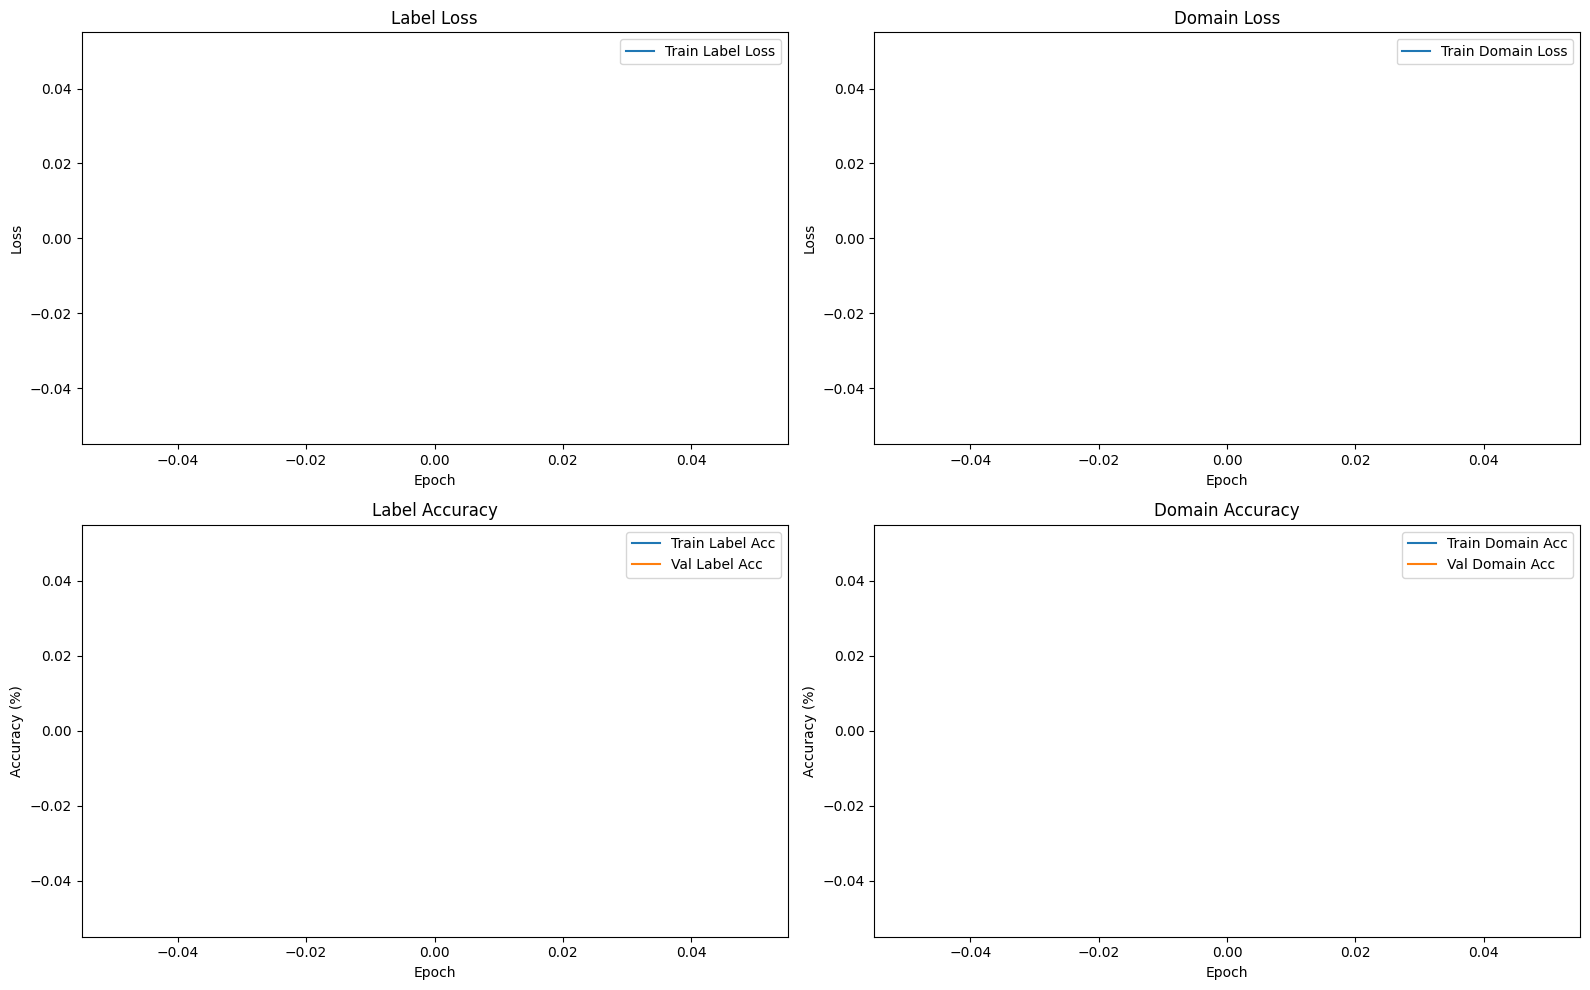

In [109]:
epochs = range(1, len(avg_losses_label) + 1)
val_epochs = range(0, len(val_label_accuracies) * 5, 5)  # if you log every 5 epochs

plt.figure(figsize=(16, 10))

# 1. Label Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, avg_losses_label, label='Train Label Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Label Loss')
plt.legend()

# 2. Domain Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, avg_losses_domain, label='Train Domain Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Domain Loss')
plt.legend()

# 3. Label Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, train_label_accuracies, label='Train Label Acc')
plt.plot(val_epochs, [v*100 for v in val_label_accuracies], label='Val Label Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Label Accuracy')
plt.legend()

# 4. Domain Accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, train_domain_accuracies, label='Train Domain Acc')
plt.plot(val_epochs, [v*100 for v in val_domain_accuracies], label='Val Domain Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Domain Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
class CustomTrainer(Trainer):
    # This method is called by _objective during an Optuna trial
    def prepare_trial_run(self):
        assert isinstance(self.trial, optuna.Trial), "Trial not set!"

        # 1. Define Hyperparameters for this trial
        #    a. Data/Loader parameters
        window_length = self.trial.suggest_categorical("window_length", [128, 256, 640]) # e.g. 64*2, 64*4, 64*10
        batch_size = self.trial.suggest_categorical("batch_size", [32, 64])

        #    b. Model architecture parameters
        kernLength = self.trial.suggest_categorical("kernLength", [64, 128, 256])
        F1 = self.trial.suggest_categorical("F1", [8, 16, 32])
        D = self.trial.suggest_categorical("D", [1, 2, 3])
        F2 = self.trial.suggest_categorical("F2", [16, 32, 64]) # F2 must be F1 * D
        hidden_dim = self.trial.suggest_categorical("hidden_dim", [64, 128, 256])
        layer_dim = self.trial.suggest_categorical("layer_dim", [1, 2, 3])
        dropout = self.trial.suggest_float("dropout", 0.1, 0.6)
        
        #    c. Optimizer parameters
        lr = self.trial.suggest_float("lr", 1e-4, 1e-2, log=True)

        # 2. Prepare the data using these parameters
        super()._prepare_data(is_trial=True, batch_size=batch_size, window_length=window_length)
        
        assert self.dataset is not None, "Dataset was not created correctly"
        n_electrodes = self.dataset.datasets[0].data[0].shape[0] # Get shape from underlying dataset

        # 3. Build the model and optimizer
        self.model = SSVEPClassifier(
            n_electrodes=n_electrodes, # Use value from data
            dropout=dropout,
            kernLength=kernLength,
            F1=F1,
            D=D,
            F2=F1 * D, # F2 is dependent on F1 and D
            hidden_dim=hidden_dim,
            layer_dim=layer_dim,
        ).to(self.device)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    # This method is called by train() for the final run
    def prepare_final_run(self):
        # 1. Get the best hyperparameters from the completed study
        study = self._get_study()
        best_params = study.best_params
        
        # 2. Prepare data using the best params
        super()._prepare_data(is_trial=False) # is_trial=False handles getting params from study
        
        assert self.dataset is not None, "Dataset was not created correctly"
        n_electrodes = self.dataset.datasets[0].data[0].shape[0]

        # 3. Build the final model and optimizer
        self.model = SSVEPClassifier(
            n_electrodes=n_electrodes,
            out_dim=2,
            dropout=best_params["dropout"],
            kernLength=best_params["kernLength"],
            F1=best_params["F1"],
            D=best_params["D"],
            F2=best_params["F1"] * best_params["D"],
            hidden_dim=best_params["hidden_dim"],
            layer_dim=best_params["layer_dim"],
        ).to(self.device)
        
        # Optional: Load pre-existing weights if you are resuming
        try:
            self.model.load_state_dict(torch.load(self.model_path))
            print(f"Loaded existing model weights from {self.model_path}")
        except Exception:
            print(f"No existing model weights found at {self.model_path}. Training from scratch.")
        
        lr = 0.00018182233882257615 # best_params["lr"]
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='max',        # “min” if you want to reduce lr when the quantity monitored has stopped decreasing
            factor=0.5,        # new_lr = lr * factor
            patience=20,        # number of epochs with no improvement after which lr will be reduced
            threshold=1e-4,    # threshold for measuring the new optimum, to only focus on significant changes
            threshold_mode='rel', # `'rel'` means compare change relative to best value. Could use `'abs'`.
            cooldown=0,        # epochs to wait before resuming normal operation after lr has been reduced
            min_lr=1e-6,       # lower bound on the lr
        )

trainer = CustomTrainer(
        data_path=data_path,
        optuna_db_path=optuna_db_path,
        model_path=model_path,
        train_epochs=500, # Final training epochs
        tune_epochs=50,   # Epochs per trial
        optuna_n_trials=50,
        task="mi",
        eeg_channels=eeg_channels,
        data_fraction=0.4
    )

In [ ]:
delete_existing = False
trainer.optimize(delete_existing)

In [ ]:
trainer.train()

In [ ]:
trainer._prepare_training(False)
trainer.model.eval()
f"test accuracy: {evaluate_model(trainer.model, trainer.eval_loader, device)}"